# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

### Задание № 1 (4 балла)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier,  RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF и SVD. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 8 моделей (два разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF, иначе точно будет слишком долго)

In [106]:
import warnings
warnings.filterwarnings("ignore")
import gensim
import pandas as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
morph = MorphAnalyzer()

In [2]:
data = pd.read_csv('avito_category_classification.csv')

In [3]:
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)

In [4]:
data['description_norm'] = data['description'].apply(normalize)

In [5]:
def eval_table(X, y, pipeline, N=6):
    # зафиксируем порядок классов
    labels = list(set(y))
    
    # метрики отдельных фолдов будет хранить в табличке
    fold_metrics = pd.DataFrame(index=labels)
    # дополнительно также соберем таблицу ошибок
    errors = np.zeros((len(labels), len(labels)))
    
    # создаем стратегию кросс-валидации
    # shuffle=True (перемешивание) - часто критично важно указать
    # т.к. данные могут быть упорядочены и модель на этом обучится
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        # fit-predict как и раньше, но сразу пайплайном
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        # записываем метрику и индекс фолда
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    # таблица для усредненных значений
    # тут мы берем колонки со значениями и усредняем их
    # часто также все метрики сразу суммируют и в конце просто делят на количество фолдов
    # но мы тут помимо среднего также хотим посмотреть на стандартное отклонение
    # чтобы понять как сильно варьируются оценки моделей
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    # добавим одну колонку со средним по всем классам
    result.loc['mean'] = result.mean().round(2)
    # проценты ошибок просто усредняем
    errors /= N
    
    return result, errors

## SGDClassifier

In [6]:
pipeline_svd = Pipeline([
    ('cv', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier())
])

In [7]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd)

In [8]:
metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.66,0.05,0.62,0.05,0.64,0.04
Телефоны,0.82,0.04,0.79,0.03,0.80,0.02
Детская одежда и обувь,0.74,0.02,0.78,0.02,0.76,0.01
Квартиры,0.95,0.01,0.96,0.03,0.96,0.02
Автомобили,0.88,0.04,0.90,0.02,0.89,0.01
Товары для детей и игрушки,0.71,0.06,0.64,0.04,0.67,0.03
Ремонт и строительство,0.63,0.08,0.47,0.03,0.53,0.03
"Одежда, обувь, аксессуары",0.72,0.02,0.77,0.03,0.74,0.01
Бытовая техника,0.64,0.07,0.53,0.04,0.58,0.04
Предложение услуг,0.79,0.03,0.76,0.06,0.77,0.03


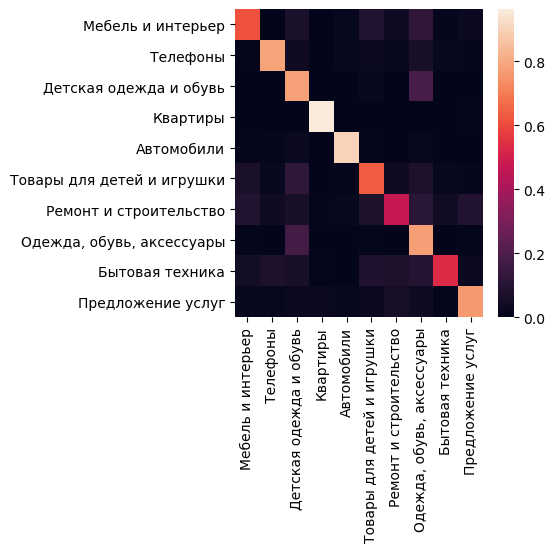

In [9]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

In [10]:
pipeline_nmf = Pipeline([
    ('cv', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', SGDClassifier())
])


In [11]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf)

In [12]:
metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.60,0.24,0.36,0.13,0.40,0.10
Телефоны,0.70,0.14,0.61,0.16,0.62,0.09
Детская одежда и обувь,0.65,0.13,0.65,0.09,0.63,0.05
Квартиры,0.76,0.17,0.95,0.03,0.83,0.12
Автомобили,0.67,0.21,0.78,0.15,0.68,0.13
Товары для детей и игрушки,0.81,0.23,0.35,0.16,0.44,0.07
Ремонт и строительство,0.21,0.18,0.09,0.09,0.12,0.11
"Одежда, обувь, аксессуары",0.64,0.08,0.68,0.06,0.65,0.01
Бытовая техника,0.37,0.30,0.16,0.24,0.13,0.10
Предложение услуг,0.55,0.17,0.39,0.25,0.39,0.17


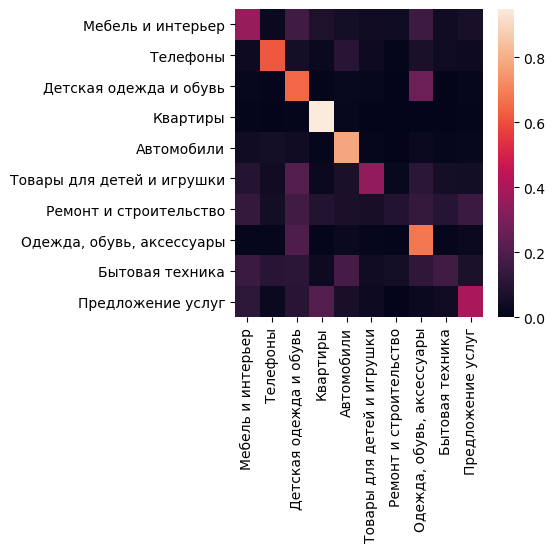

In [13]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_nmf.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [14]:
metrics_nmf - metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,-0.06,0.19,-0.26,0.08,-0.24,0.06
Телефоны,-0.12,0.10,-0.18,0.13,-0.18,0.07
Детская одежда и обувь,-0.09,0.11,-0.13,0.07,-0.13,0.04
Квартиры,-0.19,0.16,-0.01,0.00,-0.13,0.10
Автомобили,-0.21,0.17,-0.12,0.13,-0.21,0.12
Товары для детей и игрушки,0.10,0.17,-0.29,0.12,-0.23,0.04
Ремонт и строительство,-0.42,0.10,-0.38,0.06,-0.41,0.08
"Одежда, обувь, аксессуары",-0.08,0.06,-0.09,0.03,-0.09,0.00
Бытовая техника,-0.27,0.23,-0.37,0.20,-0.45,0.06
Предложение услуг,-0.24,0.14,-0.37,0.19,-0.38,0.14


SVD + SGDClassifier -- winner here.

## KNeighborsClassifier

In [15]:
pipeline_svd = Pipeline([
    ('cv', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=4, max_df=0.3)),
    ('svd', TruncatedSVD(600)),
    ('clf', KNeighborsClassifier(weights='distance'))
])

In [16]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd)
metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.39,0.05,0.30,0.05,0.33,0.05
Телефоны,0.65,0.07,0.39,0.07,0.49,0.07
Детская одежда и обувь,0.52,0.03,0.56,0.05,0.54,0.03
Квартиры,0.95,0.02,0.72,0.03,0.82,0.03
Автомобили,0.62,0.07,0.55,0.06,0.58,0.06
Товары для детей и игрушки,0.44,0.04,0.33,0.03,0.38,0.03
Ремонт и строительство,0.27,0.05,0.24,0.03,0.25,0.04
"Одежда, обувь, аксессуары",0.48,0.02,0.63,0.04,0.54,0.03
Бытовая техника,0.34,0.07,0.25,0.04,0.28,0.04
Предложение услуг,0.58,0.04,0.65,0.05,0.61,0.04


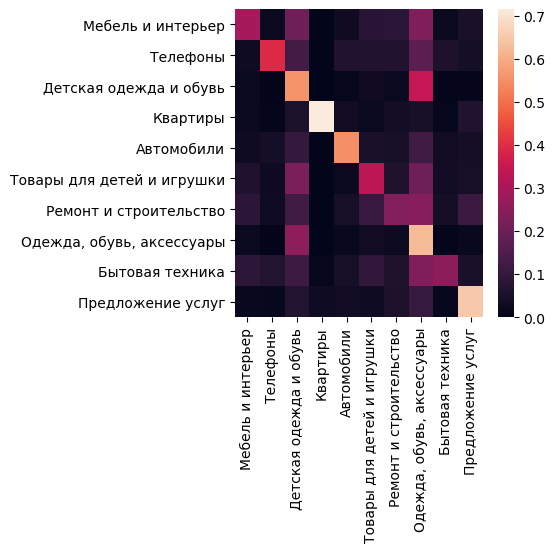

In [17]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

In [18]:
pipeline_nmf = Pipeline([
    ('cv', CountVectorizer(tokenizer=lambda x: x.split(), min_df=4, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(120)),
    ('clf', KNeighborsClassifier(weights='distance'))
])


In [19]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf)

In [20]:
metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.38,0.06,0.31,0.04,0.34,0.04
Телефоны,0.53,0.08,0.41,0.10,0.46,0.09
Детская одежда и обувь,0.57,0.02,0.49,0.01,0.53,0.01
Квартиры,0.82,0.06,0.77,0.08,0.79,0.06
Автомобили,0.60,0.07,0.64,0.05,0.62,0.05
Товары для детей и игрушки,0.37,0.04,0.34,0.06,0.35,0.05
Ремонт и строительство,0.25,0.06,0.33,0.05,0.29,0.06
"Одежда, обувь, аксессуары",0.53,0.02,0.56,0.03,0.55,0.02
Бытовая техника,0.23,0.06,0.19,0.05,0.21,0.05
Предложение услуг,0.43,0.03,0.68,0.05,0.52,0.03


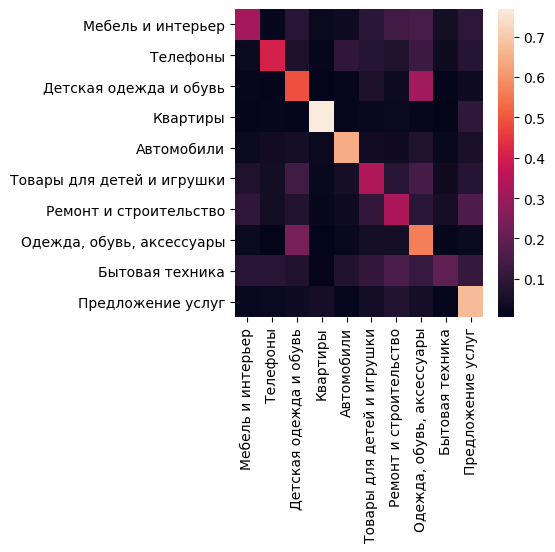

In [21]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_nmf.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [22]:
metrics_nmf - metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,-0.01,0.01,0.01,-0.01,0.01,-0.01
Телефоны,-0.12,0.01,0.02,0.03,-0.03,0.02
Детская одежда и обувь,0.05,-0.01,-0.07,-0.04,-0.01,-0.02
Квартиры,-0.13,0.04,0.05,0.05,-0.03,0.03
Автомобили,-0.02,0.00,0.09,-0.01,0.04,-0.01
Товары для детей и игрушки,-0.07,0.00,0.01,0.03,-0.03,0.02
Ремонт и строительство,-0.02,0.01,0.09,0.02,0.04,0.02
"Одежда, обувь, аксессуары",0.05,0.00,-0.07,-0.01,0.01,-0.01
Бытовая техника,-0.11,-0.01,-0.06,0.01,-0.07,0.01
Предложение услуг,-0.15,-0.01,0.03,0.00,-0.09,-0.01


SVD + KNeighborsClassifier -- winner here.

## RandomForest

In [23]:
pipeline_svd = Pipeline([
    ('cv', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=110, max_features='log2', max_depth=75, 
                                   criterion='log_loss', class_weight='balanced_subsample'))
])

In [24]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd)
metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.68,0.24,0.08,0.03,0.15,0.05
Телефоны,0.87,0.06,0.28,0.04,0.43,0.05
Детская одежда и обувь,0.41,0.02,0.67,0.02,0.51,0.01
Квартиры,0.86,0.03,0.83,0.04,0.84,0.03
Автомобили,0.82,0.08,0.49,0.07,0.61,0.07
Товары для детей и игрушки,0.58,0.08,0.13,0.02,0.21,0.03
Ремонт и строительство,0.59,0.16,0.09,0.02,0.15,0.03
"Одежда, обувь, аксессуары",0.44,0.01,0.70,0.03,0.54,0.01
Бытовая техника,0.52,0.22,0.12,0.05,0.19,0.07
Предложение услуг,0.84,0.11,0.32,0.06,0.47,0.08


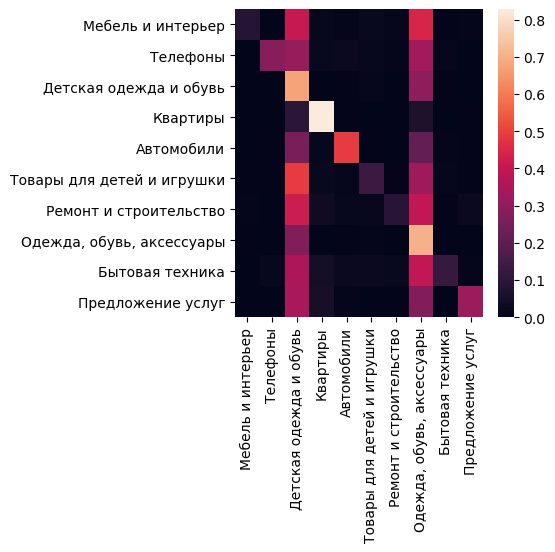

In [25]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

In [26]:
pipeline_nmf = Pipeline([
    ('cv', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=110, max_features='log2', max_depth=75, 
                                   criterion='log_loss', class_weight='balanced_subsample'))
])


In [27]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf)

In [28]:
metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.69,0.05,0.54,0.06,0.60,0.05
Телефоны,0.77,0.03,0.77,0.03,0.77,0.02
Детская одежда и обувь,0.71,0.02,0.75,0.02,0.73,0.01
Квартиры,0.90,0.02,0.96,0.02,0.93,0.02
Автомобили,0.81,0.04,0.89,0.02,0.85,0.02
Товары для детей и игрушки,0.74,0.03,0.60,0.03,0.66,0.03
Ремонт и строительство,0.63,0.07,0.43,0.05,0.51,0.06
"Одежда, обувь, аксессуары",0.68,0.01,0.77,0.01,0.72,0.00
Бытовая техника,0.70,0.11,0.35,0.07,0.46,0.08
Предложение услуг,0.69,0.06,0.70,0.04,0.70,0.05


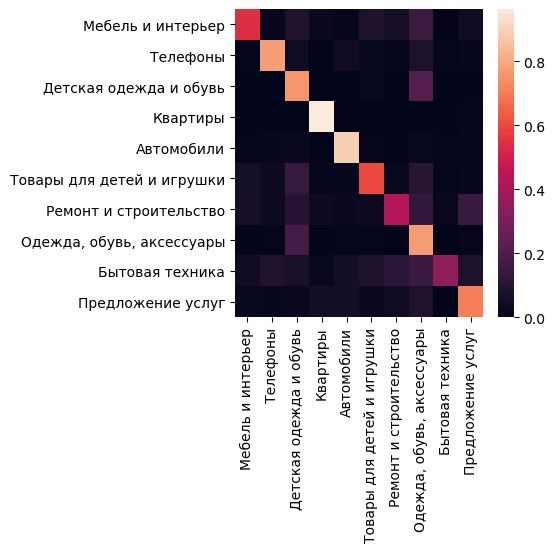

In [29]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_nmf.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [30]:
metrics_nmf - metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.01,-0.19,0.46,0.03,0.45,0.00
Телефоны,-0.10,-0.03,0.49,-0.01,0.34,-0.03
Детская одежда и обувь,0.30,0.00,0.08,0.00,0.22,0.00
Квартиры,0.04,-0.01,0.13,-0.02,0.09,-0.01
Автомобили,-0.01,-0.04,0.40,-0.05,0.24,-0.05
Товары для детей и игрушки,0.16,-0.05,0.47,0.01,0.45,0.00
Ремонт и строительство,0.04,-0.09,0.34,0.03,0.36,0.03
"Одежда, обувь, аксессуары",0.24,0.00,0.07,-0.02,0.18,-0.01
Бытовая техника,0.18,-0.11,0.23,0.02,0.27,0.01
Предложение услуг,-0.15,-0.05,0.38,-0.02,0.23,-0.03


NMF + RandomForest -- winner here.

## ExtraTreesClassifier

In [31]:
pipeline_svd = Pipeline([
    ('cv', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', ExtraTreesClassifier(max_features='log2', criterion='log_loss', class_weight='balanced_subsample'))
])

In [32]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd)
metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.59,0.18,0.09,0.04,0.16,0.06
Телефоны,0.80,0.09,0.18,0.05,0.29,0.07
Детская одежда и обувь,0.39,0.00,0.67,0.01,0.49,0.00
Квартиры,0.65,0.06,0.54,0.05,0.59,0.05
Автомобили,0.74,0.09,0.21,0.02,0.32,0.03
Товары для детей и игрушки,0.51,0.06,0.10,0.01,0.17,0.02
Ремонт и строительство,0.57,0.17,0.08,0.02,0.14,0.04
"Одежда, обувь, аксессуары",0.40,0.01,0.68,0.02,0.50,0.01
Бытовая техника,0.44,0.22,0.15,0.05,0.22,0.07
Предложение услуг,0.76,0.17,0.13,0.04,0.23,0.06


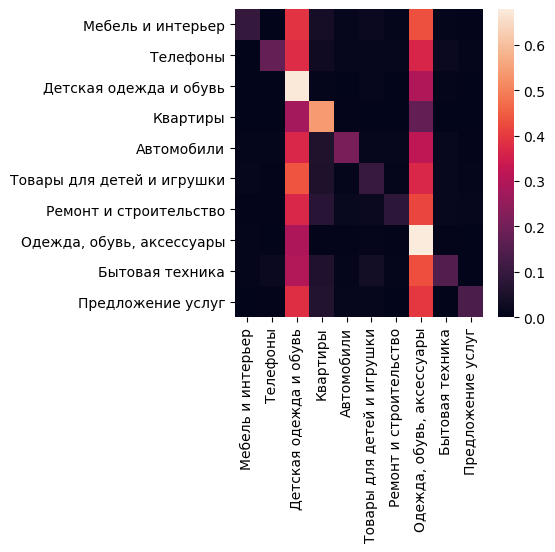

In [33]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

In [34]:
pipeline_nmf = Pipeline([
    ('cv', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', ExtraTreesClassifier(max_features='log2', criterion='log_loss', class_weight='balanced_subsample'))
])


In [35]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf)

In [36]:
metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.71,0.07,0.54,0.04,0.61,0.04
Телефоны,0.77,0.05,0.76,0.04,0.76,0.03
Детская одежда и обувь,0.72,0.03,0.75,0.02,0.73,0.02
Квартиры,0.91,0.03,0.97,0.01,0.94,0.02
Автомобили,0.86,0.03,0.88,0.04,0.87,0.03
Товары для детей и игрушки,0.73,0.04,0.55,0.02,0.62,0.02
Ремонт и строительство,0.63,0.07,0.42,0.06,0.50,0.06
"Одежда, обувь, аксессуары",0.66,0.02,0.80,0.03,0.72,0.01
Бытовая техника,0.67,0.08,0.35,0.06,0.46,0.07
Предложение услуг,0.71,0.03,0.75,0.05,0.73,0.02


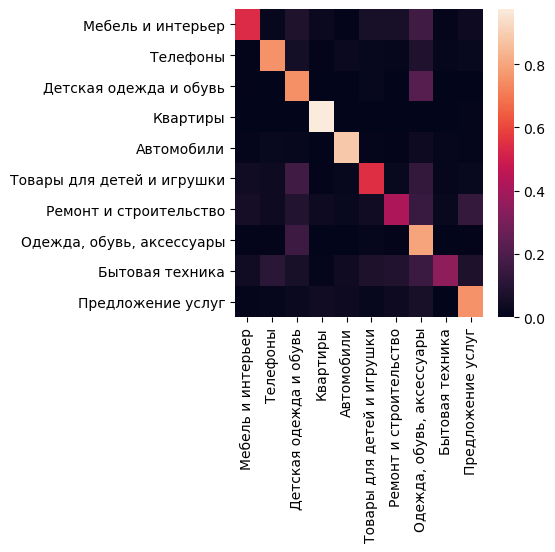

In [37]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_nmf.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [38]:
metrics_nmf - metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Мебель и интерьер,0.12,-0.11,0.45,0.00,0.45,-0.02
Телефоны,-0.03,-0.04,0.58,-0.01,0.47,-0.04
Детская одежда и обувь,0.33,0.03,0.08,0.01,0.24,0.02
Квартиры,0.26,-0.03,0.43,-0.04,0.35,-0.03
Автомобили,0.12,-0.06,0.67,0.02,0.55,0.00
Товары для детей и игрушки,0.22,-0.02,0.45,0.01,0.45,0.00
Ремонт и строительство,0.06,-0.10,0.34,0.04,0.36,0.02
"Одежда, обувь, аксессуары",0.26,0.01,0.12,0.01,0.22,0.00
Бытовая техника,0.23,-0.14,0.20,0.01,0.24,0.00
Предложение услуг,-0.05,-0.14,0.62,0.01,0.50,-0.04


NMF + ExtraTreesClassifier -- winner here.

**SVD + SGDClassifier** -- total winner.

### Задание № 2 (6 баллов)

В Gensim тоже можно добавить нграммы и tfidf. Постройте 1 модель без них (как в семинаре) и еще 3 модели (1 с нграммами, 1 с tfidf и 1 с нграммами и с tfidf). Сранивте качество с помощью метрик (перплексия, когерентность) и на глаз. Определите лучшую модель. Для каждой модели выберите 1 самую красивую на ваш взгляд тему.

Используйте данные википедии из семинара. Можете взять поменьше данных, если все обучается долго.

Важное требование - получившиеся модели не должны быть совсем плохими. Если хороших тем не получается, попробуйте настроить гиперпараметры, отфильтровать словарь по-другому. 

### Как в семинаре

In [39]:
texts = open('wiki_data.txt').read().splitlines()[:5000]
texts = ([normalize(text) for text in texts])

In [40]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [41]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [42]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [43]:
lda = gensim.models.LdaModel(corpus, 200, id2word=dictinary, passes=5)

In [44]:
lda.print_topics()

[(76,
  '0.064*"японский" + 0.060*"армия" + 0.056*"войско" + 0.032*"япония" + 0.017*"империя" + 0.017*"германия" + 0.017*"военный" + 0.016*"вооружение" + 0.016*"германский" + 0.016*"образец"'),
 (62,
  '0.034*"спорт" + 0.033*"ссср" + 0.031*"тренер" + 0.027*"чемпион" + 0.023*"выступать" + 0.022*"сборная" + 0.021*"чемпионат" + 0.019*"россия" + 0.019*"команда" + 0.019*"спортивный"'),
 (24,
  '0.036*"дивизия" + 0.035*"противник" + 0.032*"бой" + 0.027*"стрелковый" + 0.026*"войско" + 0.022*"гвардейский" + 0.021*"наступление" + 0.019*"фронт" + 0.018*"…" + 0.018*"овладеть"'),
 (78,
  '0.081*"бог" + 0.026*"рука" + 0.023*"богиня" + 0.021*"изобразить" + 0.020*"абхазия" + 0.019*"полотно" + 0.017*"смотреть" + 0.016*"говорить" + 0.014*"дверь" + 0.014*"встречать"'),
 (177,
  '0.094*"студент" + 0.084*"григорий" + 0.066*"1853" + 0.053*"континентальный" + 0.053*"аул" + 0.050*"19-й" + 0.049*"директива" + 0.037*"университет" + 0.031*"влажность" + 0.028*"отделение"'),
 (45,
  '0.040*"член" + 0.035*"наука" 

In [45]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1174.8385021433853

In [46]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=200, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)
    
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.513637126556025

Хорошая тема


(24,
  '0.036*"дивизия" + 0.035*"противник" + 0.032*"бой" + 0.027*"стрелковый" + 0.026*"войско" + 0.022*"гвардейский" + 0.021*"наступление" + 0.019*"фронт" + 0.018*"…" + 0.018*"овладеть"')

### Нграммы

In [47]:
texts = [text.split() for text in texts]
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4) # threshold можно подбирать
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts] 

!! В модели с нграммами вначале посмотрите, что получается после преобразования
Если вы выведите несколько первых текстов в ngrammed_texts, то там должно быть что-то такое:

In [48]:
[text for text in ngrammed_texts[0]][:5]

['новостройка', 'нижегородский_область', 'новостро́йка', '—', 'сельский']

In [49]:
dictinary = gensim.corpora.Dictionary((text for text in ngrammed_texts))

In [50]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [51]:
ngrammed_texts = [' '.join(text) for text in ngrammed_texts]

In [52]:
corpus = [dictinary.doc2bow(text.split()) for text in ngrammed_texts]

In [53]:
lda = gensim.models.LdaModel(corpus, 180, id2word=dictinary, passes=7)

In [54]:
lda.print_topics()

[(44,
  '0.094*"норвегия" + 0.088*"монако" + 0.082*"фестиваль" + 0.074*"норвежский" + 0.041*"шведский" + 0.041*"швеция" + 0.032*"илья" + 0.024*"хуан" + 0.017*"официальный_сайт" + 0.016*"хорх"'),
 (4,
  '0.153*"э" + 0.128*"до_н" + 0.050*"племя" + 0.038*"консул" + 0.035*"чудновский_район" + 0.026*"афганистан" + 0.026*"чудновский_р-н" + 0.024*"примыкать" + 0.021*"медведь" + 0.019*"ранний"'),
 (45,
  '0.060*"округ" + 0.024*"присоединить_к" + 0.023*"чеченский" + 0.022*"область" + 0.022*"грузинский" + 0.020*"подчинённый" + 0.019*"for" + 0.019*"подчинить" + 0.018*"понизить" + 0.017*"разделить"'),
 (103,
  '0.201*"м" + 0.176*"метр" + 0.047*"кг" + 0.044*"глубина" + 0.040*"пещера" + 0.027*"длина" + 0.024*"игра_1952" + 0.022*"массив" + 0.020*"130" + 0.019*"хельсинки_финляндия"'),
 (169,
  '0.094*"поезд" + 0.088*"северный_полюс" + 0.078*"мемориал" + 0.077*"31" + 0.044*"вблизи" + 0.042*"западный" + 0.041*"68" + 0.038*"погибший" + 0.037*"43" + 0.036*"южный_направление"'),
 (121,
  '0.021*"п" + 0.016

In [55]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1165.7963322154899

In [56]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=180, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)
    
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.49332939219705035

Хорошая тема


 (89,
  '0.058*"французский" + 0.049*"франция" + 0.031*"принц" + 0.030*"император" + 0.029*"королева" + 0.025*"король" + 0.024*"ричард" + 0.021*"брак" + 0.021*"принцесса" + 0.021*"восстание"')

### Tfidf

In [57]:
texts = open('wiki_data.txt').read().splitlines()[:5000]
texts = ([normalize(text) for text in texts])

In [58]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [59]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [60]:
corpus_ = [dictinary.doc2bow(text.split()) for text in texts]

Tfidf добавляется вот так (после векторизации и перед обучением lda)

In [61]:
tfidf = gensim.models.TfidfModel(corpus_, id2word=dictinary, )
corpus = tfidf[corpus_]

In [62]:
print(corpus[0][:10])

[(0, 0.09015466522739071), (1, 0.06857297570017572), (2, 0.040482486918318364), (3, 0.0427801213540769), (4, 0.04314298174318995), (5, 0.07883692650818122), (6, 0.06117316243827609), (7, 0.052557951005454136), (8, 0.05540480104806658), (9, 0.0532244943903728)]


In [63]:
lda = gensim.models.LdaModel(corpus, 120, id2word=dictinary, passes=9)

In [64]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

740152295082055.6

In [65]:
np.exp2(-lda.log_perplexity(corpus_[:1000]))

51313885.0525532

In [66]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=120, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)
    
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.4589300279525592

In [67]:
lda.print_topics()

[(72,
  '0.071*"театр" + 0.046*"алексей" + 0.036*"академический" + 0.027*"маргарита" + 0.022*"спектакль" + 0.019*"александр" + 0.017*"артур" + 0.016*"труппа" + 0.013*"канал" + 0.013*"сценарист"'),
 (87,
  '0.064*"оркестр" + 0.052*"инструмент" + 0.044*"музыка" + 0.024*"музыкант" + 0.022*"капелла" + 0.011*"концерт" + 0.000*"придворный" + 0.000*"зал" + 0.000*"рог" + 0.000*"дж"'),
 (37,
  '0.087*"герб" + 0.074*"монреаль" + 0.037*"канада" + 0.027*"символизировать" + 0.025*"утвердить" + 0.004*"1853" + 0.001*"преподобный" + 0.000*"крест" + 0.000*"образование" + 0.000*"квебек"'),
 (118,
  '0.045*"клетка" + 0.018*"простой" + 0.002*"стенка" + 0.000*"орган" + 0.000*"растение" + 0.000*"масло" + 0.000*"лист" + 0.000*"функция" + 0.000*"соль" + 0.000*"стебель"'),
 (40,
  '0.024*"сигнал" + 0.020*"франсуа" + 0.018*"философ" + 0.015*"акция" + 0.015*"описание" + 0.015*"заболевание" + 0.013*"концепция" + 0.012*"раздел" + 0.012*"павловский" + 0.011*"требование"'),
 (90,
  '0.084*"федерация" + 0.073*"муници

Хорошая тема

(84,
  '0.036*"полигон" + 0.030*"ядерный" + 0.006*"заряд" + 0.000*"взрыв" + 0.000*"бомба" + 0.000*"самолёт" + 0.000*"испытание" + 0.000*"1955" + 0.000*"посадка" + 0.000*"час"')

### Нграммы + tfidf

In [92]:
texts = open('wiki_data.txt').read().splitlines()[:5000]
texts = ([normalize(text) for text in texts])

In [93]:
texts = [text.split() for text in texts]
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4) 
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts] 

In [94]:
dictinary = gensim.corpora.Dictionary((text for text in ngrammed_texts))

In [95]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [96]:
ngrammed_texts = [' '.join(text) for text in ngrammed_texts]

In [97]:
corpus_ = [dictinary.doc2bow(text.split()) for text in ngrammed_texts]

In [98]:
tfidf = gensim.models.TfidfModel(corpus_, id2word=dictinary, )
corpus = tfidf[corpus_]

In [99]:
lda = gensim.models.LdaModel(corpus, 110, id2word=dictinary, passes=7)

In [100]:
np.exp2(-lda.log_perplexity(corpus_[:1000]))

11454802.735841947

In [101]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

282391759331716.9

In [102]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=110, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)
    
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.44756075375759286

In [105]:
lda.print_topics()

[(4,
  '0.016*"полтавский" + 0.004*"эксперт" + 0.000*"князь" + 0.000*"быть_избрать" + 0.000*"государственный" + 0.000*"дворянство" + 0.000*"почётный" + 0.000*"совет" + 0.000*"съезд" + 0.000*"состоять"'),
 (39,
  '0.011*"армия" + 0.009*"2008_год" + 0.008*"войско" + 0.007*"китай" + 0.007*"представлять" + 0.007*"французский" + 0.007*"президент" + 0.006*"проект" + 0.006*"14" + 0.006*"военный"'),
 (10,
  '0.074*"опера" + 0.018*"камерный" + 0.014*"театр" + 0.014*"1800" + 0.014*"премьера" + 0.010*"певица" + 0.008*"милан" + 0.008*"исполнить" + 0.006*"певец" + 0.005*"сцена"'),
 (65,
  '0.033*"тоннель" + 0.022*"2016" + 0.015*"new" + 0.008*"леди" + 0.007*"no" + 0.000*"схема" + 0.000*"пояс" + 0.000*"титул" + 0.000*"защитить" + 0.000*"выиграть"'),
 (100,
  '0.039*"лихтенштейн" + 0.030*"диалект" + 0.022*"праздник" + 0.022*"центральный_европа" + 0.020*"костюм" + 0.012*"одинаковый" + 0.012*"день" + 0.012*"грязь" + 0.008*"рождество" + 0.006*"празднование"'),
 (44,
  '0.000*"расстояние_между" + 0.000*"с

Хорошая тема

 (72,
  '0.039*"король" + 0.035*"генрих" + 0.033*"герцог" + 0.026*"ален" + 0.020*"карл" + 0.019*"принц" + 0.018*"англия" + 0.013*"принцесса" + 0.013*"королева" + 0.011*"карла"')

### Вывод

Не знаю, в чем дело, но показалось, что базовая модель, как в семинаре -- лучше всех. Хотя другими методами тоже что-то определяется.